In [1]:
import os

# Replace this with the actual file name you expect
file_name = "acne image"

if os.path.exists(file_name):
    print("Data import complete.")
else:
    print("No data available.")

Data import complete.


In [2]:
#pip install numpy pandas opencv-python matplotlib seaborn scikit-learn tensorflow


In [3]:
#pip install --upgrade tensorboard==2.19.0


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [5]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import warnings
warnings.filterwarnings('ignore')

In [6]:
!nvidia-smi

Sat Jul 12 15:17:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.57                 Driver Version: 576.57         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P5              7W /   55W |     632MiB /   8188MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import os
print(os.path.exists('acne image/train/acne/1.png'))  # must be True


True


False


Text(0.5, 1.0, 'acne')

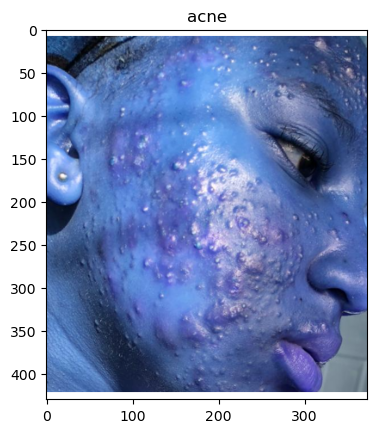

In [8]:
img = cv2.imread('acne image/train/acne/1.png')
print(img is None)
plt.imshow(img)
plt.title('acne')

Text(0.5, 1.0, 'Red Channel')

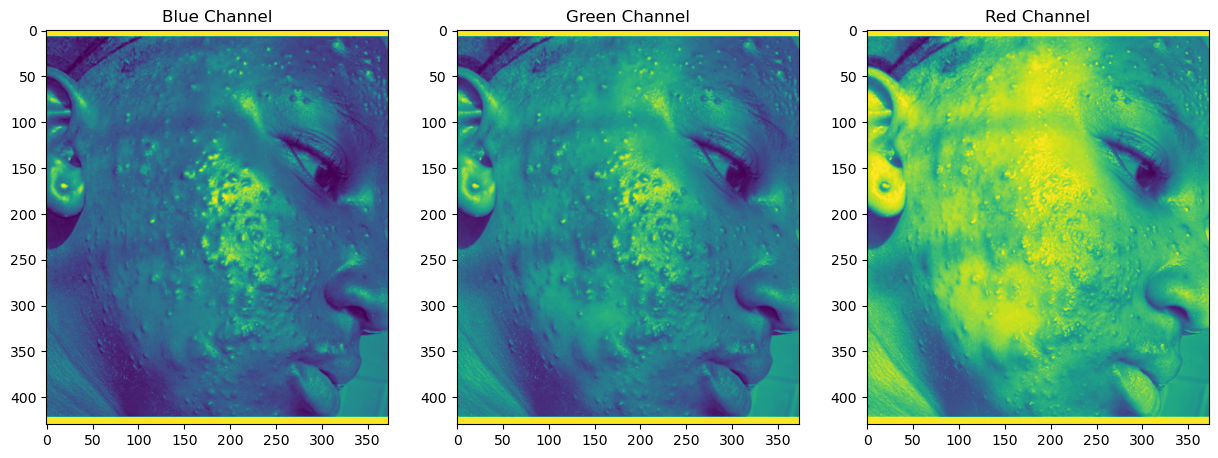

In [9]:
plt.figure(figsize = (15, 15))
b, g, r = cv2.split(img)

plt.subplot(1,3,1)
plt.imshow(b)
plt.title("Blue Channel")

plt.subplot(1,3,2)
plt.imshow(g)
plt.title("Green Channel")

plt.subplot(1,3,3)
plt.imshow(r)
plt.title("Red Channel")

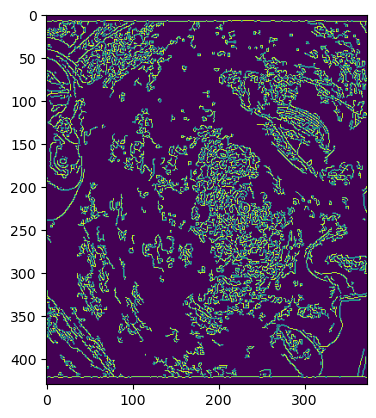

In [10]:
canny = cv2.Canny(img, 50, 170)
plt.imshow(canny)

## loading dataset

In [11]:
img_width = 224
img_height = 224
img_resized = cv2.resize(img, (img_width, img_height))


In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "acne image/train"
test_dir =  "acne image/test"
val_dir = "acne image/val"

train_data = image_dataset_from_directory(train_dir,label_mode = "categorical", image_size = (img_height, img_width), batch_size = 32, shuffle = True, seed = 42)
test_data = image_dataset_from_directory(test_dir,label_mode = "categorical", image_size = (img_height, img_width), batch_size = 32, shuffle = True, seed = 42)
val_data = image_dataset_from_directory(val_dir,label_mode = "categorical", image_size = (img_height, img_width), batch_size = 32, shuffle = True, seed = 42)

Found 2472 files belonging to 1 classes.
Found 412 files belonging to 1 classes.
Found 396 files belonging to 1 classes.


In [13]:
def channel(img):
    _, g, _ = cv2.split(img)
    return(g)

## data augmentation

In [14]:
augmentation = Sequential()

In [15]:
augmentation.add(Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.1), input_shape=(224, 224, 3)))  # <-- Add input_shape here
augmentation.add(RandomFlip(mode='horizontal_and_vertical'))
augmentation.add(RandomRotation(factor=0.2, fill_mode='nearest'))

In [16]:
augmentation.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Importing VGG19 for Transfer Learning

In [17]:
vgg19 = VGG19(input_shape = (img_height, img_width, 3), weights = 'imagenet', include_top = False)

In [18]:
vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# vgg19.trainable = False

In [20]:
# set_true = False

# for layer in vgg19.layers:
#     if layer.name == 'block5_conv1':
#         layer.trainable = True
#         set_true = True
#     if set_true:
#             layer.trainable = True 

In [21]:
# for layer in vgg19.layers:
#     print(f'Layer Name = {layer.name},      Trainable = {layer.trainable}')

# Forming the Model

In [22]:
model = Sequential()

In [23]:
# model.add(augmentation)
# model.add(vgg19)
# model.add(Flatten())
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.4))
# model.add(Dense(3000, activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1500, activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(500, activation = 'relu'))

# model.add(Flatten())
# model.add(Dense(100, activation = 'relu'))
# model.add(Dense(7, activation = 'softmax'))


##

# model.add(augmentation)
# model.add(vgg19)
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.4))
# model.add(Dense(3000, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1500, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(500, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))





In [24]:
adam = Adam(learning_rate = 0.0001)

In [ ]:
vgg19.trainable = False  # Freeze the base model

inputs = layers.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)  # Preprocess input as required by VGG19
x = vgg19(x, training=False)
x = GlobalAveragePooling2D()(x) 
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)


In [26]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [27]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 7, 7, 512) │ 20,024,384 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg19[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,155,969 (76.89 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [28]:
# setting up a checkpoint based on the best validation accuracy, so far been discovered


os.makedirs('/acne image/working', exist_ok=True)
chk_path = '/acne image/working/bestmodel.keras'

##
# checkpoint_dir = os.path.join(os.getcwd(), "acne_image", "working")
# checkpoint_path = os.path.join(checkpoint_dir, "bestmodel.keras")
# checkpoint_cb = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor="val_accuracy",
#     mode="max",
#     save_best_only=True,
#     verbose=1
# )
##

checkpoint = ModelCheckpoint(filepath = chk_path, monitor='val_accuracy', mode='max', save_best_only = True, verbose = 1)

In [29]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max', verbose = 1)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, checkpoint ]
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2069 - loss: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.18939, saving model to /acne image/working/bestmodel.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 418s 5s/step - accuracy: 0.2069 - loss: 0.0000e+00 - val_accuracy: 0.1894 - val_loss: 0.0000e+00
Epoch 2/50
31/78 ━━━━━━━━━━━━━━━━━━━━ 3:33 5s/step - accuracy: 0.2176 - loss: 0.0000e+00

In [ ]:
# history = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=50,
#     callbacks=[early_stopping, checkpoint_cb]
# )
# 2

Epoch 1/50
27/78 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - accuracy: 0.1561 - loss: 0.0000e+00

In [ ]:
#model.save('model.keras')

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and have the 'history' object
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Optionally, plot accuracy if available
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


## ResNet59 Transfer Learning

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers




In [ ]:
# Data generators (example for directory structure)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    "acne image/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(
    "acne image/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    "acne image/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

In [ ]:
# Add custom classification head
inputs = layers.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(train_generator.num_classes, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

In [ ]:

# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and have the 'history' object
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Optionally, plot accuracy if available
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


## Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

In [ ]:
# Data generators (example for directory structure)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    'acne image/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(
    'acne image/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    'acne image/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
# Load Xception base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(train_generator.num_classes, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

In [ ]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and have the 'history' object
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Optionally, plot accuracy if available
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


# Evaluating the Trained Model

In [ ]:
best_model = load_model(chk_path,safe_mode=False)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Define your lambda function
def my_lambda_function(x):
    # Example: normalize the input
    return tf.nn.l2_normalize(x, axis=-1)

# Functional API approach
inputs = Input(shape=(784,))
x = Lambda(my_lambda_function)(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
loss, acc = best_model.evaluate(test_data)

print(f"\nAccuracy = {acc}\nLoss = {loss}")

## Plotting Accuracy vs. Epochs Graph

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train accuracy', color = 'blue')
plt.plot(history.history['val_accuracy'], label = 'val accuracy', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.grid()

## Plotting Loss vs. Epochs Graph

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss', color = 'blue')
plt.plot(history.history['val_loss'], label = 'Val Loss', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.grid()

In [ ]:
model.save('model.keras')
